# GENIE Analysis
This analysis highlights challenges in standardizing fusion data from the AACR Project Genie cohort and the results of automated evidence matching

The cells below are run to set environment variables and load in FUSOR.

In [1]:
from os import environ
import logging
from pathlib import Path

# These are the configurations for the UTA and SeqRepo databases. These should
# be adjusted by the user based on the locations where these databases exist.
environ["UTA_DB_URL"] = "postgresql://anonymous@localhost:5432/uta/uta_20241220"
environ["SEQREPO_ROOT_DIR"] = "/usr/local/share/seqrepo/2024-12-20"

# Cool-Seq-Tool will log warning messages for reasons including having breakpoints
# that occur outside of the transcript boundaries and having gene partners 
# that do not have MANE select transcripts. We are silencing these warning 
# messages in the output, as FUSOR objects can still be generated for these
# cases.
logging.getLogger("cool_seq_tool").setLevel(logging.ERROR)

In [2]:
from fusor.fusor import FUSOR

fusor = FUSOR()

***Using Gene Database Endpoint: http://localhost:8000***


In [3]:
Path("data/genie_data").mkdir(parents=True, exist_ok=True)

Note: This notebook uses `data_sv.txt` from Synapse. You will need to create an account to download data from [here](https://www.synapse.org/Synapse:syn68719441). This notebook expects the `data_sv.txt` file to be in the `data` directory.

## 1. Filtering Operations
The cells below are used to perform filtering to extract fusion events from the GENIE structural variant data

In [4]:
import pandas as pd

genie_data = pd.read_csv("data/data_sv.txt", sep="\t", dtype=str)
f"The number of rows in the GENIE structural variant file is {len(genie_data)}"

'The number of rows in the GENIE structural variant file is 54124'

We want to filter for rows where both `Site1_Hugo_Symbol` and `Site2_Hugo_Symbol` are non-Null values and are different from each other. These conditions help to filter on potential fusion events in the file.

In [5]:
genie_fusions = genie_data[
    genie_data["Site1_Hugo_Symbol"].notna() &
    genie_data["Site2_Hugo_Symbol"].notna() &
    (genie_data["Site1_Hugo_Symbol"] != genie_data["Site2_Hugo_Symbol"])
]
f"The number of potential fusion events is: {len(genie_fusions)}"

'The number of potential fusion events is: 32092'

There are some rows where `INTRAGENIC` is used as a gene symbol. This symbol does not indicate a fusion event, so we want to filter on these as well.

In [6]:
genie_fusions = genie_fusions[
    (~genie_fusions["Site1_Hugo_Symbol"].isin(["INTRAGENIC"])) &
    (~genie_fusions["Site2_Hugo_Symbol"].isin(["INTRAGENIC"]))
]
f"The number of potential fusion events after removing for INTRAGENIC entries is: {len(genie_fusions)}"

'The number of potential fusion events after removing for INTRAGENIC entries is: 29067'

List the unique data centers:

In [7]:
genie_fusions["Center"].unique()

array(['MSK', 'UHN', 'VICC', 'UCSF', 'CHOP', 'DUKE', 'DFCI', 'PROV'],
      dtype=object)

The GENIE `data_sv.txt` file is a concatentation of structural variant data from 8 different data centers. We must examine data from each center separately to ensure that correct filtering has occurred.

## 2. MSK
The next cells run analyses to highlight challenges with standardizing fusion data from the MSK center.

The cell below defines helper functions that will be used

In [8]:
def is_ordered_correctly(five_prime_gene: str, three_prime_gene, annot: str) -> bool:
    """Determine if the fusion partners are oriented correctly for the MSK subset
    
    :param five_prime_gene: The assumed 5' gene partner, provided in the Site1_Hugo_Symbol column
    :param three_prime_gene: The assumed 3' gene partner, provided in the Site2_Hugo_Symbol column
    :param annot: The fusion annotation
    :return: ``True`` if the orientation is consistent, ``False`` if not
    """
    elements = annot.split(" ")
    five_prime_index = next((i for i, word in enumerate(elements) if word == five_prime_gene), None)
    three_prime_index = next((i for i, word in enumerate(elements) if word == three_prime_gene), None)
    return bool(five_prime_index < three_prime_index)

def both_genes_present(five_prime_gene: str, three_prime_gene, annot: str) -> bool:
    """Determine if both genes partners are present in the annotation
    
    :param five_prime_gene: The assumed 5' gene partner, provided in the Site1_Hugo_Symbol column
    :param three_prime_gene: The assumed 3' gene partner, provided in the Site2_Hugo_Symbol column
    :param annot: The fusion annotation
    :return: ``True`` if both partners are present, ``False`` if not
    """
    if pd.isna(annot):
        # Return False if the annotation string is not available
        return False
    elements = annot.split(" ")
    if five_prime_gene in elements and three_prime_gene in elements:
        return True
    return False

def are_breakpoints_correct(five_prime_gene: str, three_prime_gene, 
                            five_prime_description: str, three_prime_description) -> bool:
    """Determine if the supplied breakpoints describe the correct partner
    
    :param five_prime_gene: The assumed 5' gene partner, provided in the Site1_Hugo_Symbol column
    :param three_prime_gene: The assumed 3' gene partner, provided in the Site2_Hugo_Symbol column
    :param five_prime_description: The 5' gene partner location description, provided in the Site1_Description column
    :param three_prime_description: The 3' gene partner location description, provided in the Site2_Description column
    """
    if pd.isna(five_prime_description) and pd.isna(three_prime_description):
        # Return True. This corresponds to gene fusion events that were detected by Archer
        return True
    return bool(five_prime_gene in five_prime_description and three_prime_gene in three_prime_description)

In [9]:
msk_data = genie_fusions[genie_fusions["Center"] == "MSK"]
f"The number of filtered fusions from MSK is: {len(msk_data)}"

'The number of filtered fusions from MSK is: 9315'

Select rows where both gene partners appear in the annotation string

In [10]:
msk_data = msk_data[
    msk_data.apply(
        lambda row: both_genes_present(
            row["Site1_Hugo_Symbol"],
            row["Site2_Hugo_Symbol"],
            row["Annotation"]
        ),
        axis=1
    )
]
f"The number of filtered fusions from MSK is: {len(msk_data)}"

'The number of filtered fusions from MSK is: 8348'

There are some rows where the 5' and 3' partners appear to be out of order when examining the annotation string. We want to filter to include rows where we believe the partners to be in order.

In [11]:
msk_data = msk_data[
    msk_data.apply(
        lambda row: is_ordered_correctly(
            row["Site1_Hugo_Symbol"],
            row["Site2_Hugo_Symbol"],
            row["Annotation"]
        ),
        axis=1
    )
]
f"The number of filtered fusions from MSK is: {len(msk_data)}"

'The number of filtered fusions from MSK is: 7268'

There are some rows where the provided genomic breakpoints appear out of order, describing the wrong partner. We want to filter to include rows where we believe the correct genomic breakpoints are provided.

In [12]:
msk_data = msk_data[
    msk_data.apply(
        lambda row: are_breakpoints_correct(
            row["Site1_Hugo_Symbol"],
            row["Site2_Hugo_Symbol"],
            row["Site1_Description"],
            row["Site2_Description"],
        ),
        axis=1
    )
]
f"The number of filtered fusions from MSK is: {len(msk_data)}. The retanined percentage is {round(100 * len(msk_data) / 9315, 2)}%."

'The number of filtered fusions from MSK is: 4258. The retanined percentage is 45.71%.'

In [13]:
msk_data.to_csv("data/genie_data/msk_data.csv", sep="\t", index=False)

### Standardize using GENIE translator
The cell below attempts to standardize the 4,258 filtered fusions from MSK

In [14]:
from fusor.harvester import GenieHarvester
from cool_seq_tool.schemas import Assembly

harvester = GenieHarvester(fusor=fusor, assembly=Assembly.GRCH37)
msk_fusions = await harvester.load_records(fusion_path=Path("data/genie_data/msk_data.csv"))

### 2b. MSK Archer Breakdown
Some MSK rows report fusion events that are detected by Archer. These events do not report the transcript accession version, but report an exon number. We would like to see how often the fusion junction location for the provided exon is consistent across transcript versions

Run the following cell to filter for fusion events with Archer information:

In [15]:
archer_fusions = msk_data[msk_data["Event_Info"].str.contains("Archer", case=False, na=False)]
f"The number of fusions with archer annotations is: {len(archer_fusions)}"

'The number of fusions with archer annotations is: 838'

The following cell defines helper functions:

In [16]:
import re
from cool_seq_tool.schemas import Strand

def get_junction_data(gene: str, annot: str) -> list[str, int, str] | None:
    """Get junction data for gene from Archer annotation
    
    :param gene: The gene partner
    :param annot: The annotation string
    :return: A list containing the gene partner, exon number, and transcript
        accession, or None if there is no match
    """
    pattern = rf"\b({gene})\s+Exon\s*(\d+)\s*\(\s*(NM_\d+)\s*\)"
    m = re.search(pattern, annot)
    if not m:
        return None
    gene, exon, transcript = m.groups()
    return [gene, int(exon), transcript]

async def equivalent_junction(junc_list: list, five_prime: bool) -> bool:
    """Determine if junction location is consistent across transcript accession list
    
    :param junc_list: A list containing the gene, exon number, and transcript
        accession
    :param five_prime: If the five prime or three prime partner is 
        being examined
    :return: ``True`` if the junction location is equal across all transcript
        versions, ``False`` if not
    """
    transcripts = await fusor.cool_seq_tool.uta_db.get_newest_assembly_ac(ac=junc_list[2])
    transcripts = [tx for tx in transcripts if tx.startswith(junc_list[2] + ".")]
    junctions = []
    for tx in transcripts:
        exons = await fusor.cool_seq_tool.ex_g_coords_mapper._get_all_exon_coords(tx_ac=tx)
        if exons: # If exon data is available
            exon = next(e for e in exons if e.ord == junc_list[1] - 1)
            if five_prime:
                junc = exon.alt_end_i if exon.alt_strand == Strand.POSITIVE else exon.alt_start_i
            else:
                junc = exon.alt_start_i if exon.alt_strand == Strand.POSITIVE else exon.alt_end_i
            junctions.append(junc)
    return bool(len(set(junctions)) == 1)

async def consistent_junction(gene: str, annot: str, five_prime: bool):
    """Helper function to examine junction location for a partner
    
    :param gene: The gene symbol for the partner
    :param annot: The annotation string
    :param five_prime: If the five prime partner is being examined
    :return: ``True`` if the junction is the same throughout transcript versions,
        ``False`` if not
    """
    junc = get_junction_data(gene=gene, annot=annot)
    if not junc:
        return False
    eq = await equivalent_junction(junc_list=junc, five_prime=five_prime)
    return eq


async def junction_assessment(five_prime_gene: str, three_prime_gene, annot: str) -> bool:
    """Determine if both fusion junction locations for the reported joined exons
        are consistent across transcript versions
    
    :param five_prime_gene: The assumed 5' gene partner, provided in the 
        Site1_Hugo_Symbol column
    :param three_prime_gene: The assumed 3' gene partner, provided in the 
        Site2_Hugo_Symbol column
    :param annot: The fusion annotation
    :return: ``True`` if both partners have consistent junction locations across
        transcript versions, ``False`` if not
    """
    eqj = await consistent_junction(gene=five_prime_gene, annot=annot,
                                    five_prime=True)
    if not eqj:
        return False
    eqj = await consistent_junction(gene=three_prime_gene, annot=annot,
                                    five_prime=False)
    if not eqj:
        return False
    return True

Run the following cell to determine the number of Archer fusion events where the fusion junction location is consistent across transcript accession versions. The Archer annotation string **does not** report the transcript accession

In [17]:
from tqdm import tqdm

consistent_juncs = []

for idx in tqdm(archer_fusions.index, total=len(archer_fusions)):
    row = archer_fusions.loc[idx]
    same_junction = await junction_assessment(
        row["Site1_Hugo_Symbol"],
        row["Site2_Hugo_Symbol"],
        row["Annotation"]
    )
    consistent_juncs.append(same_junction)
f"The number of Archer fusion events with consistent fusion junction locations for both partners is: {sum(consistent_juncs)}"

100%|██████████| 838/838 [23:10<00:00,  1.66s/it]


'The number of Archer fusion events with consistent fusion junction locations for both partners is: 702'

## 3. UHN
The next cells standardizes data from the UHN center. This subset has consistent strcture, so no additional filtering is required

In [18]:
uhn_data = genie_fusions[genie_fusions["Center"] == "UHN"]
f"The number of filtered fusions from MSK is: {len(uhn_data)}. The retanined percentage is {round(100 * len(uhn_data) / 92, 2)}%."

'The number of filtered fusions from MSK is: 92. The retanined percentage is 100.0%.'

In [19]:
uhn_data.to_csv("data/genie_data/uhn_data.csv", sep="\t", index=False)

### Standardize using GENIE translator
The cell below attempts to standardize the 92 filtered fusions from UHN

In [20]:
uhn_fusions = await harvester.load_records(fusion_path=Path("data/genie_data/uhn_data.csv"))

## 4. VICC
The next cells standardizes data from the VICC center

In [21]:
vicc_data = genie_fusions[genie_fusions["Center"] == "VICC"]
f"The number of filtered fusions from VICC is: {len(vicc_data)}"

'The number of filtered fusions from VICC is: 450'

The VICC data includes rearrangements, which appear to be distinct from fusions. We want to only include fusions, so we will filter on the `Event_Info` field

In [22]:
vicc_data = vicc_data[~vicc_data["Event_Info"].str.contains("truncation|intragenic|rearrangement", case=False, na=False)]
f"The number of filtered fusions from VICC is: {len(vicc_data)}. The retanined percentage is {round(100 * len(vicc_data) / 450, 2)}%."

'The number of filtered fusions from VICC is: 226. The retanined percentage is 50.22%.'

In [23]:
vicc_data.to_csv("data/genie_data/vicc_data.csv", sep="\t", index=False)

### Standardize using GENIE translator
The cell below attempts to standardize the 226 filtered fusions from VICC

In [24]:
vicc_fusions = await harvester.load_records(fusion_path=Path("data/genie_data/vicc_data.csv"))

## 5. UCSF
The next cells standardizes data from the UCSF center

In [25]:
ucsf_data = genie_fusions[genie_fusions["Center"] == "UCSF"]
f"The number of filtered fusions from UCSF is: {len(ucsf_data)}"

'The number of filtered fusions from UCSF is: 1466'

Filter to only include fusions. Some non-fusion events, such as rearrangements, may not have passed the initial filters.

In [26]:
ucsf_data = ucsf_data[ucsf_data["Event_Info"].str.contains("fusion", case=False, na=False)]
f"The number of filtered fusions from UCSF is: {len(ucsf_data)}. The retanined percentage is {round(100 * len(ucsf_data) / 1466, 2)}%."

'The number of filtered fusions from UCSF is: 1419. The retanined percentage is 96.79%.'

In [27]:
ucsf_data.to_csv("data/genie_data/ucsf_data.csv", sep="\t", index=False)

### Standardize using GENIE translator
The cell below attempts to standardize the 1419 filtered fusions from UCSF

In [28]:
ucsf_fusions = await harvester.load_records(fusion_path=Path("data/genie_data/ucsf_data.csv"))

## 6. CHOP
The following cells attempt to standardize data from the CHOP center

In [29]:
chop_data = genie_fusions[genie_fusions["Center"] == "CHOP"]
f"The number of filtered fusions from CHOP is: {len(chop_data)}. The retanined percentage is {round(100 * len(chop_data) / 454, 2)}%."

'The number of filtered fusions from CHOP is: 454. The retanined percentage is 100.0%.'

All data from CHOP describe gene fusion events, so no additional filtering is needed. We can move straight to standardization with FUSOR

In [30]:
chop_data.to_csv("data/genie_data/chop_data.csv", sep="\t", index=False)

### Standardize using GENIE translator
The cell below attempts to standardize the 454 filtered fusions from CHOP

In [31]:
chop_fusions = await harvester.load_records(fusion_path=Path("data/genie_data/chop_data.csv"))

## 7. DUKE
The following cells attempt to standardize data from the DUKE center

In [32]:
duke_data = genie_fusions[genie_fusions["Center"] == "DUKE"]
f"The number of filtered fusions from DUKE is: {len(duke_data)}"

'The number of filtered fusions from DUKE is: 524'

We want to filter using the `Annotation` variable to remove any possible non-fusion events

In [33]:
duke_data = duke_data[duke_data["Annotation"].str.contains("fusion", case=False, na=False)]
f"The number of filtered fusions from DUKE is: {len(duke_data)}. The retanined percentage is {round(100 * len(duke_data) / 301, 2)}%."

'The number of filtered fusions from DUKE is: 301. The retanined percentage is 100.0%.'

In [34]:
duke_data.to_csv("data/genie_data/duke_data.csv", sep="\t", index=False)

### Standardize using GENIE translator
The cell below attempts to standardize the 301 filtered fusions from DUKE

In [35]:
duke_fusions = await harvester.load_records(fusion_path=Path("data/genie_data/duke_data.csv"))

## 8. DFCI
The following cells attempt to standardize data from the DFCI center

In [36]:
dfci_data = genie_fusions[genie_fusions["Center"] == "DFCI"]
f"The number of filtered fusions from DFCI is: {len(dfci_data)}"

'The number of filtered fusions from DFCI is: 14573'

The DFCI data does not contain genomic breakpoints. We want to validate that only fusion events have been selected, so we will run the following filter to confirm that all non-fusion events were dropped

In [37]:
dfci_data = dfci_data[~dfci_data["Event_Info"].str.contains("intragenic", case=False, na=False)]
f"The number of filtered fusions from DFCI is: {len(dfci_data)}. The retanined percentage is {round(100 * len(dfci_data) / 14573, 2)}%."

'The number of filtered fusions from DFCI is: 14573. The retanined percentage is 100.0%.'

In [38]:
dfci_data.to_csv("data/genie_data/dfci_data.csv", sep="\t", index=False)

### Standardize using GENIE translator
The cell below attempts to standardize the 14753 filtered fusions from DFCI

In [39]:
dfci_fusions = await harvester.load_records(fusion_path=Path("data/genie_data/dfci_data.csv"))

## 9. PROV
The following cells attempt to standardize data from the PROV data center

In [40]:
prov_data = genie_fusions[genie_fusions["Center"] == "PROV"]
f"The number of filtered fusions from PROV is: {len(prov_data)}"

'The number of filtered fusions from PROV is: 2193'

We want to validate that we only have fusion events by looking at the `Class` column

In [41]:
prov_data = genie_fusions[genie_fusions["Class"] == "FUSION"]
f"The number of filtered fusions from PROV is: {len(prov_data)}. The retanined percentage is {round(100 * len(prov_data) / 2193, 2)}%."

'The number of filtered fusions from PROV is: 2193. The retanined percentage is 100.0%.'

In [42]:
prov_data.to_csv("data/genie_data/prov_data.csv", sep="\t", index=False)

### Standardize using GENIE translator
The cell below attempts to standardize the 2193 filtered fusions from PROV

In [43]:
prov_fusions = await harvester.load_records(fusion_path=Path("data/genie_data/prov_data.csv"))

## 10. GENIE Data Breakdown
The following section breaks down the types of events that are returned from the GENIE cohort. The event type break down includes:
1. Events where no genomic breakpoint/fusion junction location is provided
2. Events where the provided coordinates are the precise fusion junctions
3. Events where the provided coordinates occur within 30 nucleotides of the exon start or end position
4. Events where the provided coordinates describe the rearrangement locations

In [44]:
assayed_fusions = msk_fusions + uhn_fusions + vicc_fusions + ucsf_fusions + chop_fusions + duke_fusions + dfci_fusions + prov_fusions

Run the following cells to extract rearrangement or fusion events without genomic breakpoints

In [45]:
from fusor.models import AssayedFusion, GeneElement
from ga4gh.vrs.models import SequenceLocation

def genomic_breakpoint(fusion: AssayedFusion) -> bool:
    """Determine if genomic coordinates are provided in the AssayedFusion object
    
    :param fusion: An AssayedFusion object
    :return: ``True`` if genomic breakpoints are absent for both partners,
        ``False`` if not
    """
    breakpoints = True
    for ele in fusion.structure:
        if isinstance(ele, GeneElement): # Genomic breakpoint data was unavailable
            breakpoints = False
            break
    return breakpoints

In [46]:
candidate_fusion_events = [fusion for fusion in assayed_fusions if genomic_breakpoint(fusion)]
f"The number of rearrangement/fusion events without genomic coordinates is: {len(candidate_fusion_events)}"

'The number of rearrangement/fusion events without genomic coordinates is: 5981'

Run the following cell to extract all offsets pairs for the fusion events

In [47]:
from fusor.models import TranscriptSegmentElement

def extract_offsets(fusion: AssayedFusion) -> list[int, int]:
    """Extract exon offset for fusion events
    
    :param fusion: An AssayedFusion object
    :return: A list containing the exon offsets for the two fusion partners
    """
    offsets = []
    for ele in fusion.structure:
        if isinstance(ele, TranscriptSegmentElement):
            if isinstance(ele.elementGenomicEnd, SequenceLocation):
                offsets.append(abs(ele.exonEndOffset))
            else:
                if isinstance(ele.elementGenomicStart, SequenceLocation):
                    offsets.append(abs(ele.exonStartOffset))
    return offsets

In [48]:
offsets = [extract_offsets(fusion) for fusion in candidate_fusion_events]

Both offsets are 0:

In [49]:
zero_offsets = [offset for offset in offsets if offset[0] == 0 and offset[1] == 0]
f"The number of fusion events where both offsets are 0 is: {len(zero_offsets)}"

'The number of fusion events where both offsets are 0 is: 451'

Both offsets are less than 30:

In [50]:
proximal_offsets = [offset for offset in offsets if 0 < offset[0] <= 30 and 0 < offset[1] <= 30]
f"The number of fusion events where both offsets are between 0 and 30 is: {len(proximal_offsets)}"

'The number of fusion events where both offsets are between 0 and 30 is: 886'

Both offsets are greater than 30:

In [51]:
rearrangement_offsets = [offset for offset in offsets if offset[0] > 30 and offset[1] > 30]
f"The number of fusion events where both offsets are greater than 30 is: {len(rearrangement_offsets)}"

'The number of fusion events where both offsets are greater than 30 is: 3443'

One offset is 0, the other is between 0 and 30:

In [52]:
zero_30_offsets = [
    offset for offset in offsets
    if (offset[0] == 0 and 0 < offset[1] <= 30)
    or (offset[1] == 0 and 0 < offset[0] <= 30)
]
f"The number of fusion events where one offset is 0 and the other is between 0 and 30 is: {len(zero_30_offsets)}"

'The number of fusion events where one offset is 0 and the other is between 0 and 30 is: 309'

One offset is 0, the other is greater than 30:

In [53]:
zero_30_plus_offsets = [
    offset for offset in offsets
    if (offset[0] == 0 and offset[1] > 30)
    or (offset[1] == 0 and offset[0] > 30)
]
f"The number of fusion events where one offset is 0 and the other is greater than 30 is: {len(zero_30_plus_offsets)}"

'The number of fusion events where one offset is 0 and the other is greater than 30 is: 144'

One offset is between 0 and 30, the other is greater than 30:

In [54]:
proximal_rearrangement_offsets = [
    offset for offset in offsets
    if (0 < offset[0] <= 30 and offset[1] > 30)
    or (0 < offset[1] <= 30 and offset[0] > 30)
]
f"The number of fusion events where one offset is between 0 and 30 and the other is greater than 30 is: {len(proximal_rearrangement_offsets)}"

'The number of fusion events where one offset is between 0 and 30 and the other is greater than 30 is: 748'

## 11. Using `FusionMatcher` to match GENIE fusion against the CIViC and MOA knowledgebases
The following section attempts to match standardized fusions from the GENIE cohort against the Clinical Interpretations of Variants in Cancer (CIViC) and Molecular Oncology Almanac (MOA) knowledgebases. The following cells are adapted from the demonstrative analysis notebook.

### CIViC
The cell below loads from the saved CIViC cache (from 10/11/25) and creates a list of `CategoricalFusion` objects. We are filtering for accepted and submitted variants from CIViC.

In [55]:
from fusor.harvester import CIVICHarvester

harvester = CIVICHarvester(fusor=fusor, local_cache_path="data/caches/civic_cache_20251011.pkl", include_status=["accepted", "submitted"])
civic_fusions = await harvester.load_records()

ERROR:fusor.harvester:Cannot translate fusion: FGFR3(entrez:2261)::v due to the following reason: Translation cannot proceed as GRCh37 transcripts and exons lacks genomic breakpoints
Traceback (most recent call last):
  File "/Users/rsjxa001/fusion_project/fusor/src/fusor/harvester.py", line 414, in load_records
    cat_fusion = await self.translator.translate(civic=fusion)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/rsjxa001/fusion_project/fusor/src/fusor/translator.py", line 1010, in translate
    raise ValueError(msg)
ValueError: Translation cannot proceed as GRCh37 transcripts and exons lacks genomic breakpoints
ERROR:fusor.harvester:Cannot translate fusion: TCF3(entrez:6929)::PBX1(entrez:5087) due to the following reason: Translation cannot proceed as GRCh37 transcripts and exons lacks genomic breakpoints
Traceback (most recent call last):
  File "/Users/rsjxa001/fusion_project/fusor/src/fusor/harvester.py", line 414, in load_records
    cat_fusio

There are 5 fusions from CIViC that fail to translation to `CategoricalFusion` objects:

- 1 fusion (FGFR2::?) fails to translate as the 3' partner is `?`, which represents an `UnknownGeneElement`. This class is restricted to `AssayedFusion` objects
- 4 fusions fail to translate as they are missing genomic coordinates in CIViC, which is required for fusions described using GRCh37 transcripts

### MOA
The cell below loads from the saved MOA cache (10/02/25) and creates a list of CategoricalFusion objects.

In [56]:
from fusor.harvester import MOAHarvester

harvester = MOAHarvester(fusor=fusor, cache_dir=Path("data/caches"), use_local=True)
moa_fusions = harvester.load_records()

### Create fusions list
Run the following cell to create a list of combined GENIE fusions and combined CIViC + MOA fusions

In [57]:
assayed_fusions = msk_fusions + uhn_fusions + vicc_fusions + ucsf_fusions + chop_fusions + duke_fusions + dfci_fusions + prov_fusions
categorical_fusions = civic_fusions + moa_fusions

f"The percentage of translated fusion events as a percentage of the entire GENIE data is: {round(100 * len(assayed_fusions) / len(genie_data), 2)}%."

'The percentage of translated fusion events as a percentage of the entire GENIE data is: 43.45%.'

### Define helper functions for getting exon junctions
Run the following cell to create helper functions for getting exon junctions

In [58]:
from ga4gh.vrs.models import SequenceLocation
from fusor.models import AssayedFusion, TranscriptSegmentElement
from cool_seq_tool.schemas import Strand

def segment_breakpoint_exonic(seq: SequenceLocation) -> bool:
    """Determine if a location occurs on a exon
    
    :param seq: A SequenceLocation object
    :return: ``True`` if the position occurs on a exon as indicated by the
        extension, ``False`` if not
    """
    is_exonic = None
    for ext in seq.extensions:
        if ext.name == "is_exonic":
            is_exonic = ext.value
    return is_exonic

def get_breakpoint(seq: SequenceLocation, strand: Strand, offset: int) -> int:
    """Extract breakpoint from SequenceLocation object for 
    
    :param seq: A SequenceLocation object
    :return: The breakpoint
    """
    bp= seq.end if seq.end else seq.start
    return bp - offset if strand == Strand.POSITIVE else bp + offset

async def update_fusion_structure(fusion: AssayedFusion) -> AssayedFusion:
    """Update fusion to describe junction locations instead of genomic
    breakpoints
    
    :param fusion: An AssayedFusion object
    :return: An AssayedFusion object
    """
    fusion = fusion.model_copy(deep=True)
    structure = fusion.structure
    for pos, ele in enumerate(structure):
        if isinstance(ele, TranscriptSegmentElement):
            if ele.elementGenomicEnd:
                is_exonic = segment_breakpoint_exonic(ele.elementGenomicEnd)
                if not is_exonic:
                    new_seg = await fusor.transcript_segment_element(
                        tx_to_genomic_coords=False,
                        gene=ele.gene.name,
                        transcript=ele.transcript.split(":")[1],
                        genomic_ac=ele.elementGenomicEnd.sequenceReference.id.split(":")[1],
                        seg_end_genomic=get_breakpoint(ele.elementGenomicEnd,
                                                       ele.strand,
                                                       ele.exonEndOffset))
                    structure[pos] = new_seg[0]
            else:
                is_exonic = segment_breakpoint_exonic(ele.elementGenomicStart)
                if not is_exonic:
                    new_seg = await fusor.transcript_segment_element(
                        tx_to_genomic_coords=False,
                        gene=ele.gene.name,
                        transcript=ele.transcript.split(":")[1],
                        genomic_ac=ele.elementGenomicStart.sequenceReference.id.split(":")[1],
                        seg_start_genomic=get_breakpoint(ele.elementGenomicStart,
                                                       ele.strand,
                                                       ele.exonStartOffset))
                    structure[pos] = new_seg[0]
    fusion.structure = structure
    fusion.viccNomenclature = fusor.generate_nomenclature(fusion)
    return fusion

Run the cell below to get fusion junction location from genomic breakpoints, when the provided breakpoint does not occur on an exon.

In [59]:
assayed_fusions = [await update_fusion_structure(fusion) for fusion in assayed_fusions]

### Run `FusionMatcher`
Run the following cell to query each assayed fusion from the GENIE cohort against CIViC + MOA

In [60]:
from fusor.fusion_matching import FusionMatcher

fm = FusionMatcher(assayed_fusions=assayed_fusions,
                   comparator_fusions=categorical_fusions)

matches = await fm.match_fusion()

In [61]:
f"The number of examined GENIE fusions is: {len(assayed_fusions)}"

'The number of examined GENIE fusions is: 23516'

In [62]:
returned_matches = [match for match in matches if match]
f"The number of GENIE fusions with returned matches is: {len(returned_matches)}"

'The number of GENIE fusions with returned matches is: 9268'

### Characterize fusion matches among the GENIE cohort
Run the following cells to visualize the kinds of matches that occurred among the GENIE cohort against CIViC and MOA

The functions in the following two cells are adpated from the demonstrative analysis notebook:

In [63]:
from fusor.models import CategoricalFusion
from fusor.fusion_matching import MatchType
from collections import Counter

def count_match_types(matches: list[tuple[CategoricalFusion, MatchType]]) -> dict:
    """Count the number of match types across a list of matching output
    
    :param matches: A list of tuples containing CategoricalFusion and MatchType 
        objects
    :return: A dictionary describing the number of fusions that belong in each 
        shared fusion match category"""
    element_counts = [match[1].priority // 10 for match in matches]
    element_counts = Counter(element_counts)
    map = {1: "exact", 2:"shared_genes_exact_one_partner", 3:"shared_genes", 
           4:"exact_one_partner", 5:"shared_gene_one_partner"}
    return {map[key]: value for key, value in element_counts.items()}

In [64]:
def count_match_types_fusion(match_info: list[list[tuple[CategoricalFusion, MatchType]]]) -> dict[str, int]:
    """Count the number of match types that occur across a fusion event
    
    :param match_info: A list of list of tuples containing the match information
        for a fusion
    :return: A dictionary describing match information for the fusion
    """
    categories = [
        "exact",
        "shared_genes_exact_one_partner",
        "shared_genes",
        "exact_one_partner",
        "shared_gene_one_partner",
    ]
    total_counts = Counter({cat: 0 for cat in categories})
    
    for match in match_info:
        match_dat = count_match_types(match)
        total_counts.update({k: match_dat.get(k, 0) for k in categories})
    
    return dict(total_counts)

#### Get highest returned priority match type across fusion
The cell below reports the highest priority type that is returned for the matching CategoricalFusions for each examined fusion(i.e. row from `data_sv.txt`).

In [65]:
highest_priority = []
for matching_fusion in returned_matches:
    priority = count_match_types_fusion([matching_fusion])
    for key in priority:
        if priority[key] > 0:
            highest_priority.append(key)
            break

Run the cells below to visualize the highest fusion priority type that is returned for each GENIE fusion with a matching `CategoricalFusion`.

In [66]:
match_counts = Counter(highest_priority)

columns = ["priority_type", "count"]
highest_priority_df = pd.DataFrame(columns=columns)
highest_priority_df["priority_type"] = ["exact", "shared genes exact one partner",
                                        "shared genes",  "exact one partner",
                                        "shared gene one partner"]
highest_priority_df["count"] = [match_counts["exact"], 
                                match_counts["shared_genes_exact_one_partner"],
                                match_counts["shared_genes"],
                                match_counts["exact_one_partner"],
                                match_counts["shared_gene_one_partner"]]

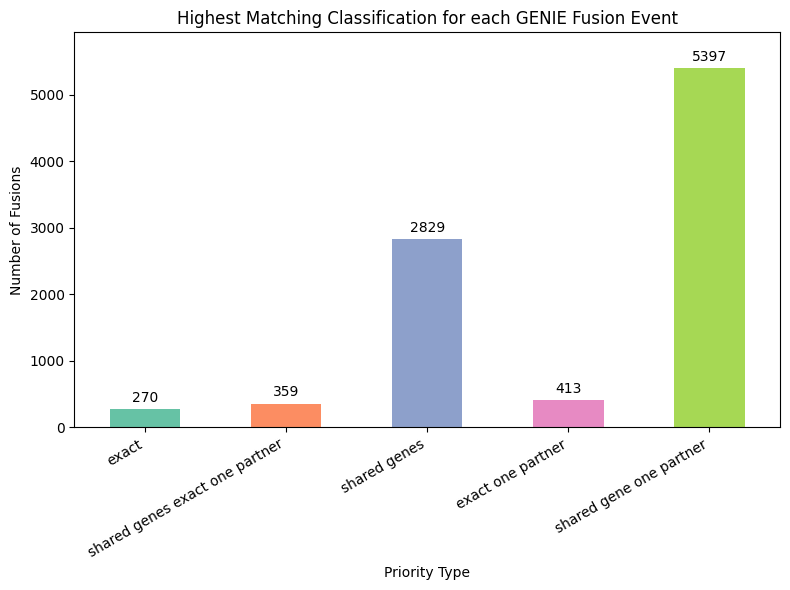

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

highest_priority_df = highest_priority_df[highest_priority_df["count"] > 0]

bar_colors = sns.color_palette("Set2")

ax = highest_priority_df.plot.bar(x="priority_type", y="count",
                                  title="Highest Matching Classification for each GENIE Fusion Event",
                                  figsize=(8, 6), color=bar_colors, legend=False)
plt.xlabel("Priority Type")
plt.ylabel("Number of Fusions")
plt.xticks(rotation=30, ha="right")
ymax = highest_priority_df["count"].max()
plt.margins(x=0.05, y=0.1)
plt.tight_layout()

for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=3)

plt.show()